<a href="https://colab.research.google.com/github/derek-shing/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [16]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [17]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [18]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=589.3771007774346, mobile=False), User(purchased=False, time_on_site=127.05443524021877, mobile=True), User(purchased=False, time_on_site=231.2691077012126, mobile=True), User(purchased=False, time_on_site=16.63405572855922, mobile=True), User(purchased=False, time_on_site=101.15010512590756, mobile=True), User(purchased=False, time_on_site=90.67403302533599, mobile=True), User(purchased=True, time_on_site=120.28670180890852, mobile=True), User(purchased=False, time_on_site=295.0738479245705, mobile=False), User(purchased=False, time_on_site=256.8040853573237, mobile=True), User(purchased=False, time_on_site=185.07620632366607, mobile=True)]


In [19]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,589.377101,False
1,False,127.054435,True
2,False,231.269108,True
3,False,16.634056,True
4,False,101.150105,True


In [20]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.1935597415404775,5.208621360441304,5.413482047088836,5.450597772523061,5.975164578744845,6.075309001498512,6.458163544753202,7.57984605285316,8.131592429020397,8.197280664688652,...,584.3046303614013,584.8037908935089,585.4236508909296,587.3670801052367,589.3771007774346,591.6875479397436,592.766494401593,595.2778464725117,597.0616908803554,597.0951523545698
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
True,1,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.602, 123.574]","(123.574, 241.954]","(241.954, 360.335]","(360.335, 478.715]","(478.715, 597.095]"
purchased,,,,,
False,296,268,152,40,63
True,60,77,34,4,6


In [25]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.602, 123.574]","(123.574, 241.954]","(241.954, 360.335]","(360.335, 478.715]","(478.715, 597.095]"
purchased,,,,,
False,0.831461,0.776812,0.817204,0.909091,0.913043
True,0.168539,0.223188,0.182796,0.090909,0.086957


In [26]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.9,0.792
True,0.1,0.208


In [53]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

group = user_data.groupby('mobile')

group_dict=dict(list(group))

group_dict[False]



,purchased,time_on_site,mobile
0,False,589.377101,False
7,False,295.073848,False
10,False,75.790452,False
16,False,40.885078,False
23,False,376.821945,False
29,False,72.689589,False
30,False,165.802367,False
33,False,194.018245,False
43,False,542.016118,False
44,False,136.522051,False


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [3]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import matplotlib.pyplot as plt
#!wget https://github.com/derek-shing/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/persons.csv
#!ls

df= pd.read_csv('https://raw.githubusercontent.com/coding-ss/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')


df.head()

#df.isnull().sum()



,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


               Unnamed: 0       age    weight  exercise_time
Unnamed: 0       1.000000 -0.000418 -0.060297      -0.020138
age             -0.000418  1.000000  0.144168      -0.273818
weight          -0.060297  0.144168  1.000000      -0.478021
exercise_time   -0.020138 -0.273818 -0.478021       1.000000


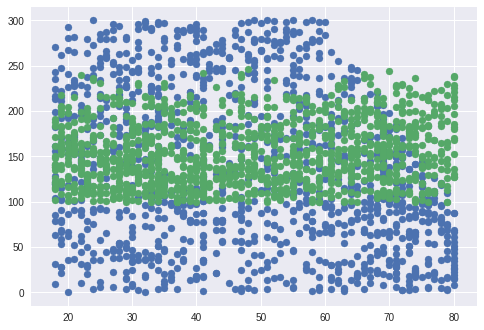

In [9]:

plt.scatter(df.age,df.exercise_time)
plt.scatter(df.age,df.weight)

print(df.corr())

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
exercise_time,,,,,,,,
"(-0.3, 37.5]",22,20,24,20,28,30,23,24
"(37.5, 75.0]",22,18,20,25,25,24,26,4
"(75.0, 112.5]",23,28,32,42,32,28,17,0
"(112.5, 150.0]",26,23,18,24,24,25,2,0
"(150.0, 187.5]",29,26,39,24,24,5,0,0
"(187.5, 225.0]",31,34,23,18,8,0,0,0
"(225.0, 262.5]",29,34,33,25,0,0,0,0
"(262.5, 300.0]",40,49,24,6,0,0,0,0


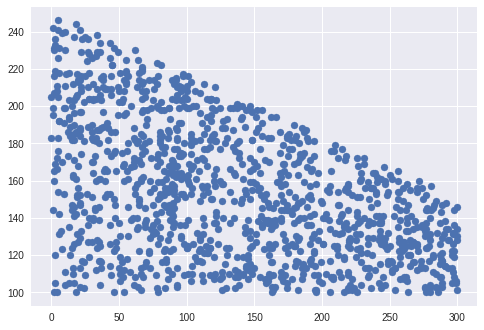

In [61]:
plt.scatter(df.exercise_time,df.weight)


age_interval = pd.interval_range(start=0,end=100,freq=10)
age_group = pd.cut(df.age,bins=age_interval,labels=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"])
weight_group= pd.cut(df.weight,8)
ex_group= pd.cut(df.exercise_time,8)

pd.crosstab(ex_group,weight_group)

In [73]:
##Try to plot the weight vs exercis time graph for each age group

age_interval = pd.interval_range(start=0,end=100,freq=10, name=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"])

df['age_group']=pd.cut(df.age,bins=age_interval,labels=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"])

print(df.head())

group_df = df.groupby(age_group)

groups = dict(list(group_df))

groups

#Interval(0, 10, closed='right')

   Unnamed: 0  age  weight  exercise_time age_group
0           0   44     118            192  (40, 50]
1           1   41     161             35  (40, 50]
2           2   46     128            220  (40, 50]
3           3   39     216             57  (30, 40]
4           4   28     116            182  (20, 30]


{Interval(0, 10, closed='right'): Empty DataFrame
 Columns: [Unnamed: 0, age, weight, exercise_time, age_group]
 Index: [],
 Interval(10, 20, closed='right'):       Unnamed: 0  age  weight  exercise_time age_group
 18            18   18     122            271  (10, 20]
 20            20   19     218             28  (10, 20]
 22            22   20     116            267  (10, 20]
 23            23   20     159            241  (10, 20]
 83            83   18     114            104  (10, 20]
 110          110   19     152            222  (10, 20]
 122          122   20     106            198  (10, 20]
 141          141   20     198            152  (10, 20]
 171          171   18     138            235  (10, 20]
 203          203   18     120            161  (10, 20]
 250          250   20     185             66  (10, 20]
 259          259   19     197             21  (10, 20]
 272          272   20     148            166  (10, 20]
 294          294   18     161             85  (10, 20]
 3

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All of the variables are continous variable

2.  What are the relationships between the variables?

The pair of variables have the highest absolute correlation value are 'weight' and 'exercise_time', which is -0.47. The weight is decreasing when exercis time increase.
There is no obvious relation between all other pair of variable


3.  Which relationships are "real", and which spurious?

The relationships between weight and exercise time is real.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)